In [21]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
import json
import re  # Added for potential label parsing, though not strictly needed in the user's provided loading logic
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import copy # Keep copy for potential deep copies if needed

In [22]:
# ==============================================================================
# Configuration Constants
# ==============================================================================
# --- Paths ---
# NOTE: Adjust these paths to your environment
DATASET_PATH = "../TestDataSet"  # Path to the original dataset (ImageFolder structure)
LABEL_JSON_PATH = os.path.join(DATASET_PATH, "labels_list.json") # Path to the JSON file mapping folder order to ImageNet indices
ADV_DATASET_PATH_TASK3 = "../AdversarialTestSet2_PGD_Refactored" # Output directory for PGD adversarial images

# --- Model & Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS = 'IMAGENET1K_V1'
# --- PGD Attack Parameters ---
# Epsilon: Max L-infinity perturbation allowed (relative to [0, 1] pixel range)
EPSILON = 0.02
# Alpha: Step size for each PGD iteration (often eps / iters or smaller)
PGD_ALPHA = 0.005 # As provided in user's code
# Iterations: Number of PGD steps
PGD_ITERS = 5     # As provided in user's code

# --- Dataloader Parameters ---
BATCH_SIZE = 32  # Adjusted for potentially faster generation/evaluation
NUM_WORKERS = 0  # Adjust based on your system


In [23]:
# Load model
resnet34 = torchvision.models.resnet34(weights=WEIGHTS)
resnet34.eval().to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# --- Normalization Parameters (ImageNet Defaults) ---
MEAN_NORMS = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(DEVICE)
STD_NORMS = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(DEVICE)

# --- Visualization ---
NUM_VIS_EXAMPLES = 5 # Number of examples to visualize

In [25]:
print(f"--- Configuration ---")
print(f"Device: {DEVICE}")
print(f"Original Dataset Path: {DATASET_PATH}")
print(f"Label JSON Path: {LABEL_JSON_PATH}")
print(f"Adversarial Output Path: {ADV_DATASET_PATH_TASK3}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epsilon (L-inf): {EPSILON}")
print(f"PGD Alpha: {PGD_ALPHA}")
print(f"PGD Iterations: {PGD_ITERS}")
print(f"-------------------\n")

--- Configuration ---
Device: cuda
Original Dataset Path: ../TestDataSet
Label JSON Path: ../TestDataSet\labels_list.json
Adversarial Output Path: ../AdversarialTestSet2_PGD_Refactored
Batch Size: 32
Epsilon (L-inf): 0.02
PGD Alpha: 0.005
PGD Iterations: 5
-------------------



In [26]:
# ==============================================================================
# Normalization & Denormalization Transforms
# ==============================================================================
# Normalize transform (applied when loading data)
normalize = transforms.Normalize(MEAN_NORMS.squeeze().tolist(), STD_NORMS.squeeze().tolist())
inv_normalize = transforms.Normalize(
    mean=(-MEAN_NORMS / STD_NORMS).squeeze().tolist(),
    std=(1.0 / STD_NORMS).squeeze().tolist()
)

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [27]:
# ==============================================================================
# Load Original Dataset and Map Labels
# ==============================================================================
print(f"\nLoading original dataset from: {DATASET_PATH}")
if not os.path.isdir(DATASET_PATH):
    raise FileNotFoundError(f"Dataset directory not found at '{DATASET_PATH}'.")
if not os.path.isfile(LABEL_JSON_PATH):
     raise FileNotFoundError(f"Label JSON file not found at '{LABEL_JSON_PATH}'.")

with open(os.path.join(DATASET_PATH, "labels_list.json"), "r") as f:
    label_lines = json.load(f)
true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]


Loading original dataset from: ../TestDataSet


In [28]:
imagefolder = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=transform)
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[i]
    for i, class_name in enumerate(imagefolder.classes)
}
imagefolder.samples = [
    (path, folder_to_imagenet_index[os.path.basename(os.path.dirname(path))])
    for path, _ in imagefolder.samples
]

dataloader = DataLoader(imagefolder, batch_size=1, shuffle=False)

In [29]:
os.makedirs(ADV_DATASET_PATH_TASK3, exist_ok=True)

In [30]:
# Denormalize transform (useful for saving/visualization)
# Re-implementation for clarity, similar to user's inv_normalize
# Inside Denormalize class __init__ method:
class Denormalize(transforms.Normalize):
    """Denormalizes a tensor image with mean and standard deviation."""
    def __init__(self, mean, std):
        # Specify dtype=torch.float32 here
        mean = torch.as_tensor(mean, dtype=torch.float32) # No need for device here
        std = torch.as_tensor(std, dtype=torch.float32)   # No need for device here

        # Add epsilon for numerical stability before inverting std
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        # Initialize the parent class with lists (as required by transforms.Normalize)
        super().__init__(mean=mean_inv.tolist(), std=std_inv.tolist())

    def __call__(self, tensor):
        # Ensure tensor is on the correct device if needed, but parent call handles dtype
        # The parent __call__ method will handle the normalization calculation correctly
        return super().__call__(tensor.clone()) # Cloning is good practice

denorm_transform = Denormalize(MEAN_NORMS, STD_NORMS)

In [31]:
def pgd_attack(image, label, epsilon, alpha, steps):
    orig = image.detach()
    perturbed = image.clone().detach().requires_grad_(True)

    for _ in range(steps):
        output = resnet34(perturbed)
        loss = torch.nn.functional.cross_entropy(output, label)
        resnet34.zero_grad()
        loss.backward()
        grad = perturbed.grad.data.sign()
        perturbed = perturbed + alpha * grad
        perturbed = torch.max(torch.min(perturbed, orig + EPSILON), orig - EPSILON)
        perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

    return perturbed.detach()

In [32]:
# Adversarial image generation
adv_images = []
true_labels = []
pred_changed = []

for idx, (img, label) in enumerate(tqdm(dataloader, desc="PGD Attack")):
    img, label = img.to(DEVICE), label.to(DEVICE)
    with torch.no_grad():
        orig_pred = resnet34(img).argmax(dim=1).item()

    adv_img = pgd_attack(img.clone(), label, EPSILON, PGD_ALPHA, PGD_ITERS)
    with torch.no_grad():
        adv_pred = resnet34(adv_img).argmax(dim=1).item()

    # Save adversarial image
    adv_images.append(adv_img.squeeze().cpu())
    true_labels.append(label.item())
    pred_changed.append(orig_pred != adv_pred)

    # Save to disk
    out_path = os.path.join(ADV_DATASET_PATH_TASK3, f"{idx:04d}.png")
    torchvision.utils.save_image(inv_normalize(adv_img.squeeze().cpu()).clamp(0, 1), out_path)

PGD Attack:   0%|          | 0/500 [00:00<?, ?it/s]

PGD Attack: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s]



🔍 PGD Attack Visualizations (Changed Predictions):


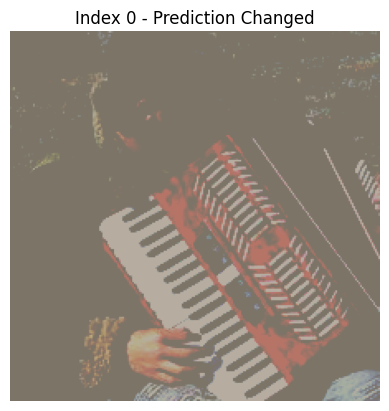

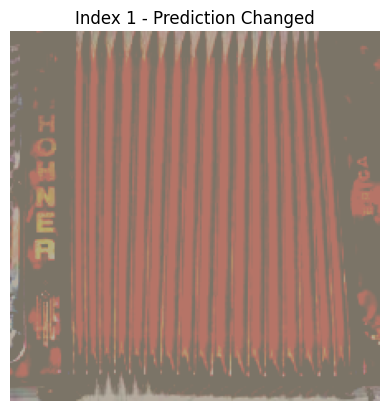

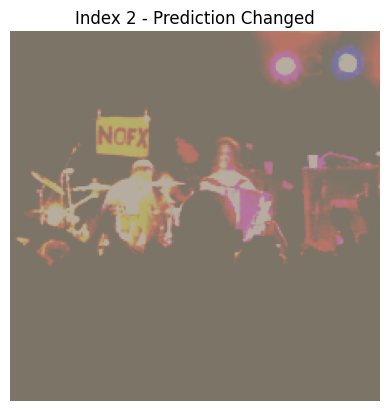

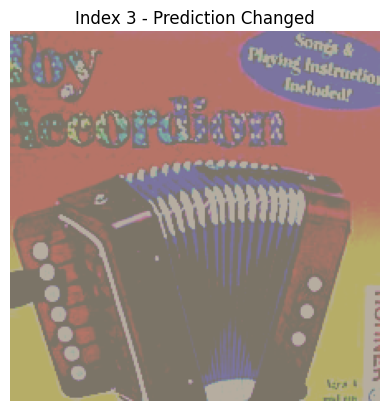

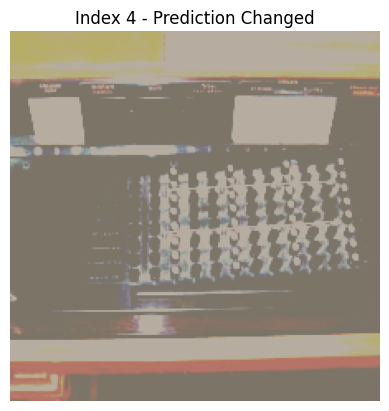

In [33]:
# Visualization (3–5 changed predictions)
print("\n🔍 PGD Attack Visualizations (Changed Predictions):")
count = 0
for i in range(len(adv_images)):
    if pred_changed[i]:
        plt.imshow(inv_normalize(adv_images[i]).permute(1, 2, 0).clamp(0, 1))
        plt.title(f"Index {i} - Prediction Changed")
        plt.axis("off")
        plt.show()
        count += 1
    if count == 5:
        break

In [34]:
# Evaluation
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, image_tensors, labels):
        self.images = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv_dataset = AdvDataset(adv_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32)

In [35]:
def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, top1 = outputs.topk(1, dim=1)
            _, top5 = outputs.topk(5, dim=1)
            top1_correct += (top1.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            total += labels.size(0)
    return 100 * top1_correct / total, 100 * top5_correct / total

In [36]:
top1_adv, top5_adv = evaluate(resnet34, adv_loader)
print(f"\n🔥 PGD Adversarial Top-1 Accuracy: {top1_adv:.2f}%")
print(f"🔥 PGD Adversarial Top-5 Accuracy: {top5_adv:.2f}%")


🔥 PGD Adversarial Top-1 Accuracy: 1.00%
🔥 PGD Adversarial Top-5 Accuracy: 10.60%
